# Keyphrase Extraction in multi-documents accounting with geospacial associations

This is a exploratory notebook.

In [2]:
import os

import joblib
import pandas as pd
from nltk.stem import PorterStemmer
import simplemma

from geo_kpe_multidoc import (GEO_KPE_MULTIDOC_CACHE_PATH,
                              GEO_KPE_MULTIDOC_OUTPUT_PATH)
from geo_kpe_multidoc.evaluation.evaluation_tools import (
    evaluate_kp_extraction, postprocess_dataset_labels, postprocess_res_labels)
from geo_kpe_multidoc.models.pre_processing.pre_processing_utils import \
    lemmatize

import matplotlib.pyplot as plt

2023-04-26 16:39:44.724939: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 16:39:44.900116: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-26 16:39:44.900144: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-26 16:39:45.813126: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
lemmer = "en"
stemmer = PorterStemmer()

In [3]:
def load_results_filter(path, filter_ = "*"):
    results, true_labels = {}, {}
    with os.scandir(path) as it:
        for entry in it:
            if not entry.name.startswith('.') and entry.is_file() and entry.name.startswith(filter_):
                r = joblib.load(entry)
                results[r["doc"]] = [(r["top_n_scores"], [name for name, score in r["top_n_scores"]])]
                true_labels[r["doc"]] = [r["gold"]]
    return results, true_labels

In [4]:
def load_results(path):
    results, true_labels = {}, {}
    with os.scandir(path) as it:
        for entry in it:
            if not entry.name.startswith('.') and entry.is_file():
                r = joblib.load(entry)
                results[r["doc"]] = [(r["top_n_scores"], [name for name, score in r["top_n_scores"]])]
                true_labels[r["doc"]] = [r["gold"]]
    return results, true_labels

In [5]:
results_sbert, true_labels_sbert = load_results(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, "DUC2001-EmbedRank-sbert"))
results_long, true_labels_long = load_results(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, "DUC2001-EmbedRankManual-ToLong-T4"))

In [6]:
def stem_phrase(phrase, stemmer):
    return " ".join(
        [stemmer.stem(w) for w in simplemma.simple_tokenizer(phrase)]
    ).lower()


In [7]:
def build_model_scores_dataframe(results, true_labels):
    df = pd.DataFrame()
    for doc, candidade_values in results.items():
        candidates_score, _ = candidade_values[0]
        gold_kp = [stem_phrase(kp, stemmer) for kp in true_labels[doc][0]]

        rows = [
            {
                "doc": doc,
                "candidate": stem_phrase(candidate, stemmer),
                "score": score,
                "in_gold": stem_phrase(candidate, stemmer) in gold_kp,
            }
            for candidate, score in candidates_score
        ]

        df = pd.concat([df, pd.DataFrame.from_records(rows)])

    return df


In [8]:
sbert_results = build_model_scores_dataframe(results_sbert, true_labels_sbert)
long_results = build_model_scores_dataframe(results_long, true_labels_long)


In [9]:
long_results["candidate"]

0                                      degre
1                                 rescu crew
2                                 r c porter
3     nation transport safeti board investig
4                                    showeri
                       ...                  
45                                    mexico
46                                    sunday
47                                  era ship
48                           seat t-2 buckey
49                             old lexington
Name: candidate, Length: 36271, dtype: object

Text(0.5, 1.0, 'DUC2001 Longformer - similarity scores - Gold vs Not Gold ')

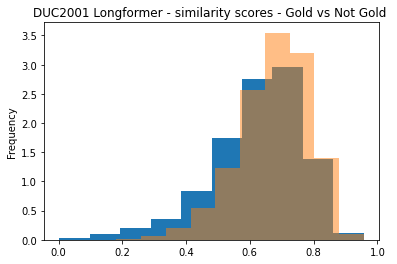

In [36]:
fig, ax = plt.subplots()
ax = long_results['score'].plot.hist(density=True)
ax = long_results[long_results['in_gold'] == True]['score'].plot.hist(density=True, alpha=0.5)
plt.title("DUC2001 Longformer - similarity scores - Gold vs Not Gold ")

Text(0.5, 1.0, 'DUC2001 Sbert Original - similarity scores - Gold vs Not Gold ')

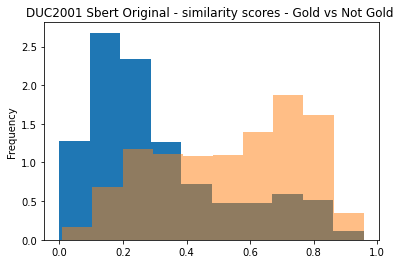

In [37]:
fig, ax = plt.subplots()
ax = sbert_results['score'].plot.hist(density=True)
ax = sbert_results[sbert_results['in_gold'] == True]['score'].plot.hist(density=True, alpha=0.5)
plt.title("DUC2001 Sbert Original - similarity scores - Gold vs Not Gold ")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4fdc1bb820>,
      dtype=object)

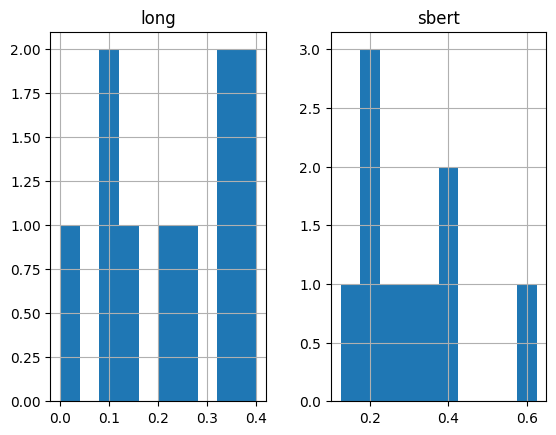

In [23]:
longformer_DUC2001_EmbedRank_F1["model"] = 'long'
sbert_DUC2001_EmbedRank_F1["model"] = 'sbert'
pd.concat([longformer_DUC2001_EmbedRank_F1.set_index('model', append=True), sbert_DUC2001_EmbedRank_F1.set_index('model', append=True) ]).unstack(level=1).loc[:, "F1_10"].hist()


